# Bonus-Track Assignment 2: Sequential MNIST classification task

The MNIST dataset is a common dataset used in computer vision. It consists of 60000 images of 28x28 pixels of handwritten digits from 0 to 9. A strategy is to flatten the 28x28 pixels into 784 dimensional vectors and feed them as input to a multilayer perceptron. The Sequential MNIST task (sMNIST) is a challenging task devised to test the ability of an RNN model to learn long-term dependencies. The sMNIST consists of considering the flattened MNIST vectors as a time series of 784 time steps, i.e. we feed an RNN with one pixel per time step starting from the top left of the image ending to the bottom right. After 784 time steps the RNN provides a 10-dimensional output containing the softmax probabilities of the input being one of the 10 digits. NB: you don’t have to produce an output for each time step, but rather you just need to use the last hidden state to perform the classification. The rationale is that the RNN, after “listening” to the whole time series, has encoded in its hidden state the information necessary to classify the time series.

# Bonus Track Assignment 4: benchmarking RNN models on the sequential MNIST task

The sequential MNIST can be downloaded as described in the Lab 3—bonus track assignment #2. The goal of this assignment is to compare the performance-achievable by various RNN models on this task. As such:

1) Write your custom code that solves the sequential MNIST time-series classification task with several recurrent neural networks. You must consider at least: a vanilla RNN model, a gated recurrent neural network (e.g., GRU and/or LSTM). Optionally, you can implement / use a bidirectional RNN, a deep RNN, and an Antisymmetric RNN (as described in lecture slides “Part3_Lecture2.pdf”).
2) For every model, identify a suitable set of hyper-parameters and their possible values to explore by model selection
3) Perform model selection, choosing, for each model individually, the values of the hyper-parameters on the validation set.
4) For each model individually, train the network with the chosen configuration on the whole training set, and assess it on the test set. For each model, run a number of Ng identical experiments (same hyperparameters’ values, different random seeds), where Ng >= 5, and record the training and test accuracies achieved. Compute averages and std over the Ng repetitions for each model individually.
5) Provide a Table in which you report the training and test statistics of the achieved results (computed as indicated in the previous point).

## Libraries

In [ ]:
from itertools import product
import pandas as pd

import copy, os, json
from typing import Tuple

import torch
from torch import cuda
from torch.nn import RNN, LSTM, GRU
from torch.nn.utils import clip_grad_norm_
from torch.optim.adam import Adam
from torch.utils.data import DataLoader, Dataset

# To work with Google colab
#!wget https://raw.githubusercontent.com/jacons/Computational-NeuroScience-Lab/master/Utils/utils.py
#!wget https://raw.githubusercontent.com/jacons/Computational-NeuroScience-Lab/master/LAB3_1/Assignment2_4/model.py

from Utils.utils import compute_acc, Sequential_mnist, show_loss
from LAB3_1.Assignment2_4.model import sMNIST_model

--2023-06-28 17:54:46--  https://raw.githubusercontent.com/jacons/Computational-NeuroScience-Lab/master/LAB3_1/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3679 (3.6K) [text/plain]
Saving to: ‘utils.py.1’

utils.py.1          100%[===================>]   3.59K  --.-KB/s    in 0s      

2023-06-28 17:54:46 (36.3 MB/s) - ‘utils.py.1’ saved [3679/3679]

--2023-06-28 17:54:46--  https://raw.githubusercontent.com/jacons/Computational-NeuroScience-Lab/master/LAB3_1/Assignment2_4/model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 

In [ ]:
gpu = 'cuda' if cuda.is_available() else 'cpu'
if not os.path.exists('caches'):
    os.makedirs('caches')

## Trainer and Grid-search function

In [ ]:
class RNN_trainer:
    def __init__(self, rnn_type:str, hidden:int, layers:int, bi:bool):

        if rnn_type == "RNN":
            rnn = RNN(1, hidden, num_layers=layers, bidirectional=bi, batch_first=True)
        elif rnn_type == "LSTM":
            rnn = LSTM(1, hidden, num_layers=layers, bidirectional=bi, batch_first=True)
        elif rnn_type == "GRU":
            rnn = GRU(1, hidden, num_layers=layers, bidirectional=bi, batch_first=True)
        else:
            rnn = None

        # model
        self.model = sMNIST_model(rnn, hidden=hidden, bi=bi).to(gpu)

    def fit(self, ds:Dataset, epochs:int=2, lr:float=0.001):
        """
        Give the raw dataset ds, the number of epochs and the learning rate.
        It fits the model and returns the training loss history.
        """

        # Build a dataloader with the training dataset
        loader = DataLoader(ds, batch_size=64, shuffle=True)
        opt = Adam(self.model.parameters(), lr)
        history_tr = [] # Keep track the behavior of loss

        loss, y, y_pred =  None, None, None

        self.model.train()
        for i in range(epochs):

            for x, y in loader:
                x,y = x.to(gpu), y.to(gpu) # perform the output

                opt.zero_grad(set_to_none=True)
                loss, y_pred = self.model(x, y)
                loss.backward()
                clip_grad_norm_(self.model.parameters(), 0.8)
                opt.step()

            if compute_acc(y_pred, y) >= 0.98:
                break
            history_tr.append(loss.item())


            if i % 50 == 0:
                print(".")
            else:
                print(".", end="")

        print("")
        return torch.tensor(history_tr)

    def validate(self, ds:Dataset) -> Tuple:
        """
        Given a validation dataset, it performs the loss
        """

        # Build a dataloader with the dataset taken
        loader = DataLoader(ds, batch_size=512)
        cum_loss, cum_acc = 0, 0

        self.model.eval()
        with torch.no_grad():
            for x, y in loader:
                x,y = x.to(gpu), y.to(gpu)
                loss, y_pred = self.model(x, y)
                cum_loss += loss.item()
                cum_acc += compute_acc(y_pred, y)

        cum_loss /= len(loader)
        cum_acc /= len(loader)

        return  cum_loss, cum_acc

In [ ]:
class GridSearch:

    def __init__(self, rnn_type:str, parameters_grid:dict, tr:Dataset, dev:Dataset):

        self.rnn_type = rnn_type
        all_configs = [dict(zip(parameters_grid.keys(), configs)) for configs in product(*parameters_grid.values())]

        print("Number of configurations to try: ",len(all_configs))

        """
        Returns the performance in each configuration:

            rank = a list of results for each configuration
            best = best model used to final retrain
            loss = training loss history of the best model
        """
        rank, best, loss = self.run(tr, dev, all_configs)

        # we sort by validation loss
        rank = sorted(rank, key=lambda conf: -conf[2])

        print("\nThe best solution in ", rank[0])
        self.best_config = rank[0][0]
        self.best_model = best
        self.tr_loss = loss

    def run(self, tr:Dataset, dev:Dataset, configs:list):
        """
        In the grid search, we explore all configurations provided and try to find the best
        hyperparameter configuration using the training set to train the model and the validation
        set to compare the performance among all models instantiated by configurations.
        """

        rank = [] # the keep in track the configuration and the corresponding performance

        # we save the best trained model and the training loss during the epochs
        best, loss = None, None
        best_dev_acc = 0

        for idx, config in enumerate(configs):
            print("Config: ",idx)

            trainer = RNN_trainer(self.rnn_type, hidden=config["units"],
                                  layers=config["layers"], bi=config["bi"])

            history  = trainer.fit(tr, config["epochs"], config["lr"])
            _, acc_vl = trainer.validate(dev)

            rank.append((config, round(history[-1].item(), 4), round(acc_vl, 4)))

            print(f'Results: Acc tr: {round(history[-1].item(), 4)}', f'Acc vl: {round(acc_vl, 4)}')

            # we keep the best model
            if best_dev_acc < acc_vl:
                best_dev_acc = acc_vl
                loss = copy.deepcopy(history)
                best = copy.deepcopy(trainer)

        return rank, best, loss

### Retrieve the dataset and Hold out

In [ ]:
tr_dataset = Sequential_mnist("train", root="./../../Sources/MNIST")
dev_dataset = Sequential_mnist("dev", root="./../../Sources/MNIST")
ts_dataset = Sequential_mnist("test", root="./../../Sources/MNIST")

100%|██████████| 9912422/9912422 [00:00<00:00, 102796438.70it/s]


Extracting ..\sources\MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ..\sources\MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 70142266.26it/s]


Extracting ..\sources\MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ..\sources\MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27708231.26it/s]


Extracting ..\sources\MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ..\sources\MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10867386.63it/s]


Extracting ..\sources\MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ..\sources\MNIST/MNIST/raw



In [ ]:
json_dictionary = {}
save_best_models = []

## Grid search Vanilla RNN

In [ ]:
ranges_to_explore = {
    "units" : [10, 20],
    "epochs" : [200],
    "lr" : [0.001, 0.004],
    "layers": [1, 2],
    "bi" : [True]
}

In [ ]:
gs = GridSearch("RNN", ranges_to_explore, tr_dataset, dev_dataset)
best_config =  gs.best_config
best_model = gs.best_model

json_dictionary["RNN"] = best_config

Number of configurations to try:  8
Config:  0
.
..................................................
..................................................
..................................................
.................................................
Results: Acc tr: 2.2912 Acc vl: 0.1067
Config:  1
.
..................................................
..................................................
..................................................
.................................................
Results: Acc tr: 1.0863 Acc vl: 0.4706
Config:  2
.
..................................................
..................................................
..................................................
.................................................
Results: Acc tr: 2.2536 Acc vl: 0.1064
Config:  3
.
..................................................
..................................................
..................................................
.................................

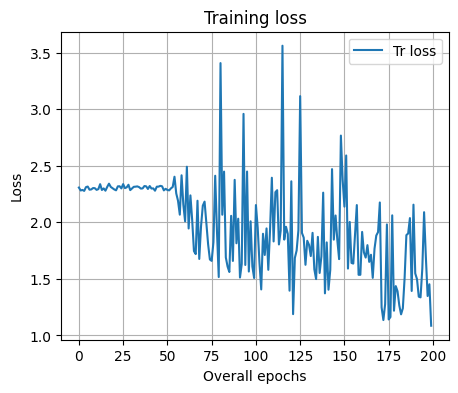

In [ ]:
show_loss(gs.tr_loss)

In [ ]:
tr_loss, tr_acc = best_model.validate(tr_dataset)
print(f'Train loss: {round(tr_loss, 6)}', f'Accuracy: {round(tr_acc, 3)}')

dev_loss, dev_acc = best_model.validate(dev_dataset)
print(f'Train loss: {round(dev_loss, 6)}', f'Accuracy: {round(dev_acc, 3)}')

test_loss, test_acc = best_model.validate(ts_dataset)
print(f'Train loss: {round(test_loss, 6)}', f'Accuracy: {round(test_acc, 3)}')

Train loss: 1.404929 Accuracy: 0.468
Train loss: 1.376933 Accuracy: 0.471
Train loss: 1.392449 Accuracy: 0.471


#### Final retrain with Training and Validation set (with the best configuration)

In [ ]:
best_rrn_model = RNN_trainer("RNN", hidden=best_config["units"],
                            layers=best_config["layers"], bi=best_config["bi"])
# we use both training and validation as a training set, using the best parameters
# found in the previous model selection
final_tr = Sequential_mnist("train-dev", root="..\sources\MNIST")
tr_history = best_rrn_model.fit(final_tr, best_config["epochs"]+100, lr=best_config["lr"])

.
..................................................
..................................................
..................................................
..................................................
..................................................
.................................................


In [ ]:
tr_loss, tr_acc = best_rrn_model.validate(final_tr)
print(f'Train loss: {round(tr_loss, 6)}', f'Accuracy: {round(tr_acc, 3)}')

test_loss, test_acc  = best_rrn_model.validate(ts_dataset)
print(f'Train loss: {round(test_loss, 6)}', f'Accuracy: {round(test_acc, 3)}')

Train loss: 1.693329 Accuracy: 0.347
Train loss: 1.68463 Accuracy: 0.346


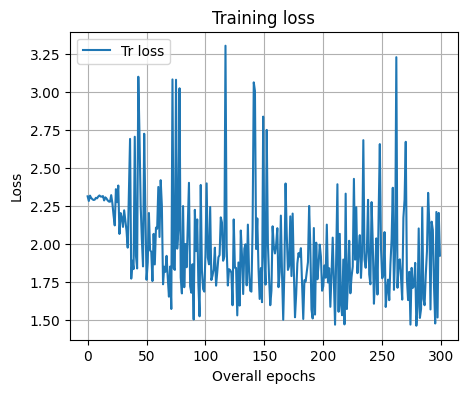

In [ ]:
show_loss(tr_history)

In [ ]:
save_best_models.append(best_rrn_model.model)

## Grid search LSTM

In [ ]:
gs = GridSearch("LSTM",ranges_to_explore, tr_dataset, dev_dataset)
best_config =  gs.best_config
best_model = gs.best_model

json_dictionary["LSTM"] = best_config

Number of configurations to try:  8
Config:  0
.
..................................................
..................................................
..................................................
................................................
Results: Acc tr: 0.9854 Acc vl: 0.7693
Config:  1
.
..................................................
......................
Results: Acc tr: 0.4527 Acc vl: 0.8508
Config:  2
.
..................................................
..................................................
..................................................
.................................................
Results: Acc tr: 2.2027 Acc vl: 0.1891
Config:  3
.
..................................................
..................................................
..................................................
.................................................
Results: Acc tr: 2.2995 Acc vl: 0.1064
Config:  4
.
..................................................
..........

In [ ]:
tr_loss, tr_acc = best_model.validate(tr_dataset)
print(f'Train loss: {round(tr_loss, 6)}', f'Accuracy: {round(tr_acc, 3)}')

dev_loss, dev_acc = best_model.validate(dev_dataset)
print(f'Train loss: {round(dev_loss, 6)}', f'Accuracy: {round(dev_acc, 3)}')

test_loss, test_acc = best_model.validate(ts_dataset)
print(f'Train loss: {round(test_loss, 6)}', f'Accuracy: {round(test_acc, 3)}')

Train loss: 0.595853 Accuracy: 0.799
Train loss: 0.549834 Accuracy: 0.814
Train loss: 0.569783 Accuracy: 0.808


#### Final retrain with Training and Validation set (with the best configuration)

In [ ]:
best_lstm_model = RNN_trainer("LSTM", hidden=best_config["units"],
                             layers=best_config["layers"], bi=best_config["bi"])
# we use both training and validation as a training set, using the best parameters
# found in the previous model selection
final_tr = Sequential_mnist("train-dev", root="..\sources\MNIST")

tr_history = best_lstm_model.fit(final_tr, best_config["epochs"], lr=best_config["lr"])

.
..................................................
........................


In [ ]:
tr_loss, tr_acc = best_lstm_model.validate(final_tr)
print(f'Train loss: {round(tr_loss, 6)}', f'Accuracy: {round(tr_acc, 3)}')

test_loss, test_acc  = best_lstm_model.validate(ts_dataset)
print(f'Train loss: {round(test_loss, 6)}', f'Accuracy: {round(test_acc, 3)}')

Train loss: 0.21012 Accuracy: 0.939
Train loss: 0.219859 Accuracy: 0.938


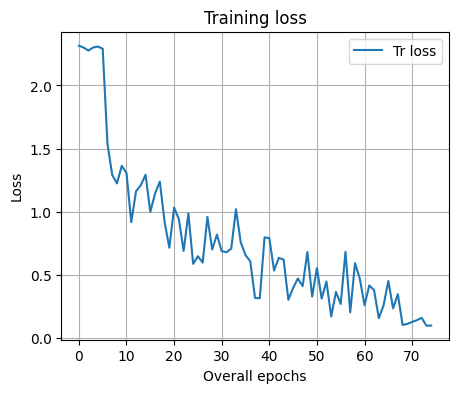

In [ ]:
show_loss(tr_history)

In [ ]:
save_best_models.append(best_lstm_model.model)

## Grid search GRU

In [ ]:
gs = GridSearch("GRU",ranges_to_explore, tr_dataset, dev_dataset)
best_config =  gs.best_config
best_model = gs.best_model

json_dictionary["GRU"] = best_config

Number of configurations to try:  8
Config:  0
.
..................................................
..................................................
..................................................
.........................................
Results: Acc tr: 0.5979 Acc vl: 0.7043
Config:  1
.
............................
Results: Acc tr: 0.4476 Acc vl: 0.8334
Config:  2
.
..................................................
..
Results: Acc tr: 0.4221 Acc vl: 0.8325
Config:  3
.
.........................
Results: Acc tr: 0.1398 Acc vl: 0.9396
Config:  4
.
.............................
Results: Acc tr: 0.2866 Acc vl: 0.8607
Config:  5
.
........................
Results: Acc tr: 0.0847 Acc vl: 0.9443
Config:  6
.
...................
Results: Acc tr: 0.2486 Acc vl: 0.9315
Config:  7
.
.....
Results: Acc tr: 0.4136 Acc vl: 0.9571

The best solution in  ({'units': 20, 'epochs': 200, 'lr': 0.004, 'layers': 2, 'bi': True}, 0.4136, 0.9571)


In [ ]:
tr_loss, tr_acc = best_model.validate(tr_dataset)
print(f'Train loss: {round(tr_loss, 6)}', f'Accuracy: {round(tr_acc, 3)}')

dev_loss, dev_acc = best_model.validate(dev_dataset)
print(f'Train loss: {round(dev_loss, 6)}', f'Accuracy: {round(dev_acc, 3)}')

test_loss, test_acc = best_model.validate(ts_dataset)
print(f'Train loss: {round(test_loss, 6)}', f'Accuracy: {round(test_acc, 3)}')

Train loss: 0.165636 Accuracy: 0.952
Train loss: 0.148266 Accuracy: 0.957
Train loss: 0.153083 Accuracy: 0.956


#### Final retrain with Training and Validation set (with the best configuration)

In [ ]:
best_gru_model = RNN_trainer("GRU",hidden=best_config["units"],
                             layers=best_config["layers"], bi=best_config["bi"])
# we use both training and validation as a training set, using the best parameters
# found in the previous model selection
tr_history = best_gru_model.fit(final_tr, best_config["epochs"], lr=best_config["lr"])

.
........


In [ ]:
tr_loss, tr_acc = best_gru_model.validate(final_tr)
print(f'Train loss: {round(tr_loss, 6)}', f'Accuracy: {round(tr_acc, 3)}')

test_loss, test_acc  = best_gru_model.validate(ts_dataset)
print(f'Train loss: {round(test_loss, 6)}', f'Accuracy: {round(test_acc, 3)}')

Train loss: 0.120781 Accuracy: 0.965
Train loss: 0.122385 Accuracy: 0.963


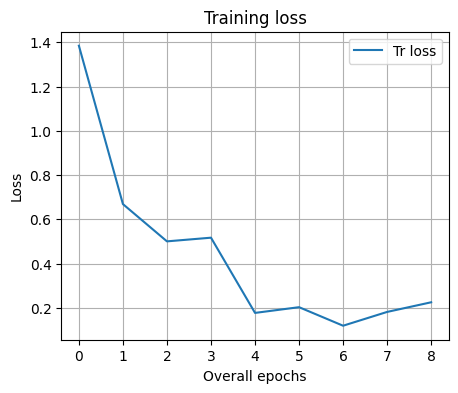

In [ ]:
show_loss(tr_history)

In [ ]:
save_best_models.append(best_gru_model.model)

In [ ]:
torch.save(save_best_models,"caches/best_models.pt")
with open("caches/metrics_rnn_lstm_gru.json", "w") as outfile:
    outfile.write(json.dumps(json_dictionary))

## Build the statistical table

In [ ]:
def experiments(name:str, n:int):

    losses_tr, accuracies_tr = torch.zeros(n), torch.zeros(n)
    losses_ts, accuracies_ts = torch.zeros(n), torch.zeros(n)

    for i in range(n):
        print("Experiment ", i)
        torch.random.manual_seed(torch.randint(1,10000,(1,)).item())
        bc = json_dictionary[name]

        trainer = RNN_trainer(name, hidden=bc["units"], layers=bc["layers"], bi=bc["bi"])
        trainer.fit(tr_dataset, bc["epochs"], bc["lr"])

        loss_tr, acc_tr = trainer.validate(tr_dataset)
        loss_ts, acc_ts = trainer.validate(ts_dataset)

        losses_tr[i], losses_ts[i] = loss_tr, loss_ts
        accuracies_tr[i], accuracies_ts[i] = acc_tr, acc_ts

    results = {"training_loss": (losses_tr.mean(), losses_tr.std()),
               "test_loss": (losses_ts.mean(), losses_ts.std()),
               "training_acc": (accuracies_tr.mean(), accuracies_tr.std()),
               "test_acc": (accuracies_ts.mean(), accuracies_ts.std())}

    return results

def review(name:str):
  t = table_result[name]
  result = (round(t["training_loss"][0].item(), 3),
            round(t["training_loss"][1].item(),3),

            str(round(t["training_acc"][0].item() *100, 3))+"%",
            round(t["training_acc"][1].item()*100, 3),

            round(t["test_loss"][0].item(), 3),
            round(t["test_loss"][1].item(), 3),

            str(round(t["test_acc"][0].item() *100, 3))+ "%",
            round(t["test_acc"][1].item() *100, 3))
  return result

In [ ]:
table_result = {
    "results_rnn": experiments("RNN", 5),
    "results_lstm": experiments("LSTM", 5),
    "results_gru":  experiments("GRU", 5)
}
with open("caches/stat_table.json", "w") as outfile:
    outfile.write(json.dumps(json_dictionary))

Experiment  0
.
..................................................
..................................................
..................................................
.................................................
Experiment  1
.
..................................................
..................................................
..................................................
.................................................
Experiment  2
.
..................................................
..................................................
..................................................
.................................................
Experiment  3
.
..................................................
..................................................
..................................................
.................................................
Experiment  4
.
..................................................
..................................................
......

In [ ]:
pd.DataFrame(data=[review("results_rnn"),review("results_lstm"),review("results_gru")],
             index=["RNN","LSTM","GRU"],
             columns=["TR loss Avg","TR loss std","TR Acc Avg","TR Acc std","TS loss Avg","TS loss std","TS Acc Avg","TS Acc std"])

,TR loss Avg,TR loss std,TR Acc Avg,TR Acc std,TS loss Avg,TS loss std,TS Acc Avg,TS Acc std
RNN,1.797,0.078,30.181%,3.450,1.791,0.071,30.019%,2.943
LSTM,0.367,0.111,87.53%,4.394,0.368,0.108,87.53%,4.406
GRU,0.232,0.049,92.655%,1.702,0.229,0.046,92.834%,1.797
